# Auto Chat Response Analysis
## Draft Message Adoption & Usage Analysis

**Analysis includes:**
- Monthly draft generation and adoption rates
- `insert_to_type_box` adoption analysis (采纳率)
- User engagement patterns
- User details (name, role) from MongoDB
- Usage by role analysis

## Setup & Imports

In [15]:
# Import all required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from pymongo import MongoClient
from bson.objectid import ObjectId
import os
from dotenv import load_dotenv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported")

✅ All libraries imported


In [16]:
# Load environment variables and setup connections
load_dotenv()

# MySQL connection
DATABASE_URL = os.getenv('MYSQL_DATABASE_URL')
if DATABASE_URL:
    DATABASE_URL = DATABASE_URL.replace('mysql+aiomysql://', 'mysql+pymysql://')
mysql_engine = create_engine(DATABASE_URL, echo=False, pool_pre_ping=True)

# MongoDB connection
MONGO_URI = os.getenv('MONGO_DATABASE_URI')
mongo_client = MongoClient(MONGO_URI)
mongo_db = mongo_client['UnifiedCare']
employees_collection = mongo_db['employees']
role_assignments_collection = mongo_db['role_assignments']

print("✅ MySQL connected")
print("✅ MongoDB connected")
print(f"   MongoDB Database: {mongo_db.name}")
print(f"   Collections: employees, role_assignments")

✅ MySQL connected
✅ MongoDB connected
   MongoDB Database: UnifiedCare
   Collections: employees, role_assignments


## Part 1: Monthly Statistics & Adoption Rate

In [17]:
# Query monthly statistics for Auto Chat Response
query_monthly = text("""
    SELECT
        DATE_FORMAT(timestamp, '%Y-%m') as month,
        DATE_FORMAT(timestamp, '%Y-%m-01') as month_date,
        COUNT(DISTINCT user_id) as unique_users,
        COUNT(*) as total_drafts,
        COUNT(DISTINCT session_id) as total_sessions,
        COUNT(DISTINCT patient_id) as unique_patients,
        SUM(CASE WHEN insert_to_type_box = 1 THEN 1 ELSE 0 END) as adopted_drafts,
        ROUND(SUM(CASE WHEN insert_to_type_box = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as adoption_rate,
        SUM(CASE WHEN closed_by_user = 1 THEN 1 ELSE 0 END) as closed_drafts,
        AVG(total_tokens) as avg_tokens,
        SUM(total_tokens) as sum_tokens,
        AVG(llm_process_time) as avg_process_time,
        COUNT(DISTINCT DATE(timestamp)) as active_days
    FROM ai.history_chat_draft
    WHERE timestamp >= '2024-01-01'
    GROUP BY DATE_FORMAT(timestamp, '%Y-%m'), DATE_FORMAT(timestamp, '%Y-%m-01')
    ORDER BY month
""")

print("🔄 Querying Auto Chat Response monthly data...")

with mysql_engine.connect() as conn:
    df_monthly = pd.read_sql(query_monthly, conn)

# Convert month_date to datetime
df_monthly['month_date'] = pd.to_datetime(df_monthly['month_date'])

print(f"✅ Monthly data loaded: {len(df_monthly)} months found")
print(f"   Date range: {df_monthly['month'].min()} to {df_monthly['month'].max()}")
print()

# Display the data
display(df_monthly[['month', 'unique_users', 'total_drafts', 'adopted_drafts', 'adoption_rate', 'closed_drafts', 'total_sessions']])

🔄 Querying Auto Chat Response monthly data...
✅ Monthly data loaded: 12 months found
   Date range: 2024-12 to 2025-11



,month,unique_users,total_drafts,adopted_drafts,adoption_rate,closed_drafts,total_sessions
0,2024-12,103,12631,1604.0,12.70,286.0,0
1,2025-01,116,22408,2345.0,10.47,332.0,0
2,2025-02,75,5425,1355.0,24.98,207.0,0
3,2025-03,72,7562,2138.0,28.27,315.0,0
4,2025-04,73,8260,2039.0,24.69,316.0,0
5,2025-05,69,8175,1587.0,19.41,327.0,0
6,2025-06,58,7866,1490.0,18.94,250.0,0
7,2025-07,68,7363,1359.0,18.46,231.0,0
8,2025-08,66,7591,1456.0,19.18,210.0,0
9,2025-09,67,6944,1312.0,18.89,351.0,0


In [18]:
# Calculate growth metrics
df_monthly['user_growth'] = df_monthly['unique_users'].diff()
df_monthly['user_growth_pct'] = df_monthly['unique_users'].pct_change() * 100
df_monthly['draft_growth'] = df_monthly['total_drafts'].diff()
df_monthly['draft_growth_pct'] = df_monthly['total_drafts'].pct_change() * 100
df_monthly['adoption_rate_change'] = df_monthly['adoption_rate'].diff()

print("📈 Monthly Growth Analysis:")
display(df_monthly[['month', 'unique_users', 'user_growth', 'total_drafts', 'draft_growth', 'adoption_rate', 'adoption_rate_change']])

📈 Monthly Growth Analysis:


,month,unique_users,user_growth,total_drafts,draft_growth,adoption_rate,adoption_rate_change
0,2024-12,103,NaN,12631,NaN,12.70,NaN
1,2025-01,116,13.0,22408,9777.0,10.47,-2.23
2,2025-02,75,-41.0,5425,-16983.0,24.98,14.51
3,2025-03,72,-3.0,7562,2137.0,28.27,3.29
4,2025-04,73,1.0,8260,698.0,24.69,-3.58
5,2025-05,69,-4.0,8175,-85.0,19.41,-5.28
6,2025-06,58,-11.0,7866,-309.0,18.94,-0.47
7,2025-07,68,10.0,7363,-503.0,18.46,-0.48
8,2025-08,66,-2.0,7591,228.0,19.18,0.72
9,2025-09,67,1.0,6944,-647.0,18.89,-0.29


In [19]:
# Summary statistics
print("=" * 70)
print("📊 AUTO CHAT RESPONSE MONTHLY SUMMARY")
print("=" * 70)

print(f"\n📅 Time Period:")
print(f"   From: {df_monthly['month'].min()}")
print(f"   To: {df_monthly['month'].max()}")
print(f"   Total Months: {len(df_monthly)}")

print(f"\n👥 Users:")
print(f"   Peak Month: {df_monthly.loc[df_monthly['unique_users'].idxmax(), 'month']} ({df_monthly['unique_users'].max():,} users)")
print(f"   Lowest Month: {df_monthly.loc[df_monthly['unique_users'].idxmin(), 'month']} ({df_monthly['unique_users'].min():,} users)")
print(f"   Average per Month: {df_monthly['unique_users'].mean():,.0f} users")

print(f"\n📝 Drafts:")
print(f"   Total Drafts Generated: {df_monthly['total_drafts'].sum():,}")
print(f"   Total Adopted (insert_to_type_box=1): {df_monthly['adopted_drafts'].sum():,}")
print(f"   Total Closed by User: {df_monthly['closed_drafts'].sum():,}")
print(f"   Overall Adoption Rate: {(df_monthly['adopted_drafts'].sum() / df_monthly['total_drafts'].sum() * 100):.2f}%")
print(f"   Average Monthly Adoption Rate: {df_monthly['adoption_rate'].mean():.2f}%")

print(f"\n📈 Trends:")
if len(df_monthly) > 1:
    first_month_users = df_monthly.iloc[0]['unique_users']
    last_month_users = df_monthly.iloc[-1]['unique_users']
    overall_growth = ((last_month_users - first_month_users) / first_month_users * 100) if first_month_users > 0 else 0
    print(f"   Overall User Growth: {overall_growth:+.1f}% (from {first_month_users:,.0f} to {last_month_users:,.0f})")
    
    best_adoption_idx = df_monthly['adoption_rate'].idxmax()
    worst_adoption_idx = df_monthly['adoption_rate'].idxmin()
    print(f"   Best Adoption Month: {df_monthly.loc[best_adoption_idx, 'month']} ({df_monthly.loc[best_adoption_idx, 'adoption_rate']:.2f}%)")
    print(f"   Lowest Adoption Month: {df_monthly.loc[worst_adoption_idx, 'month']} ({df_monthly.loc[worst_adoption_idx, 'adoption_rate']:.2f}%)")

print(f"\n💰 Token Usage:")
print(f"   Total Tokens: {df_monthly['sum_tokens'].sum():,.0f}")
print(f"   Average per Month: {df_monthly['sum_tokens'].mean():,.0f} tokens")
print(f"   Average per Draft: {(df_monthly['sum_tokens'].sum() / df_monthly['total_drafts'].sum()):,.0f} tokens")

print("\n" + "=" * 70)

📊 AUTO CHAT RESPONSE MONTHLY SUMMARY

📅 Time Period:
   From: 2024-12
   To: 2025-11
   Total Months: 12

👥 Users:
   Peak Month: 2025-01 (116 users)
   Lowest Month: 2025-11 (56 users)
   Average per Month: 74 users

📝 Drafts:
   Total Drafts Generated: 104,251
   Total Adopted (insert_to_type_box=1): 18,404.0
   Total Closed by User: 3,389.0
   Overall Adoption Rate: 17.65%
   Average Monthly Adoption Rate: 19.27%

📈 Trends:
   Overall User Growth: -45.6% (from 103 to 56)
   Best Adoption Month: 2025-03 (28.27%)
   Lowest Adoption Month: 2025-01 (10.47%)

💰 Token Usage:
   Total Tokens: 837,516,275
   Average per Month: 69,793,023 tokens
   Average per Draft: 8,034 tokens



## Visualizations

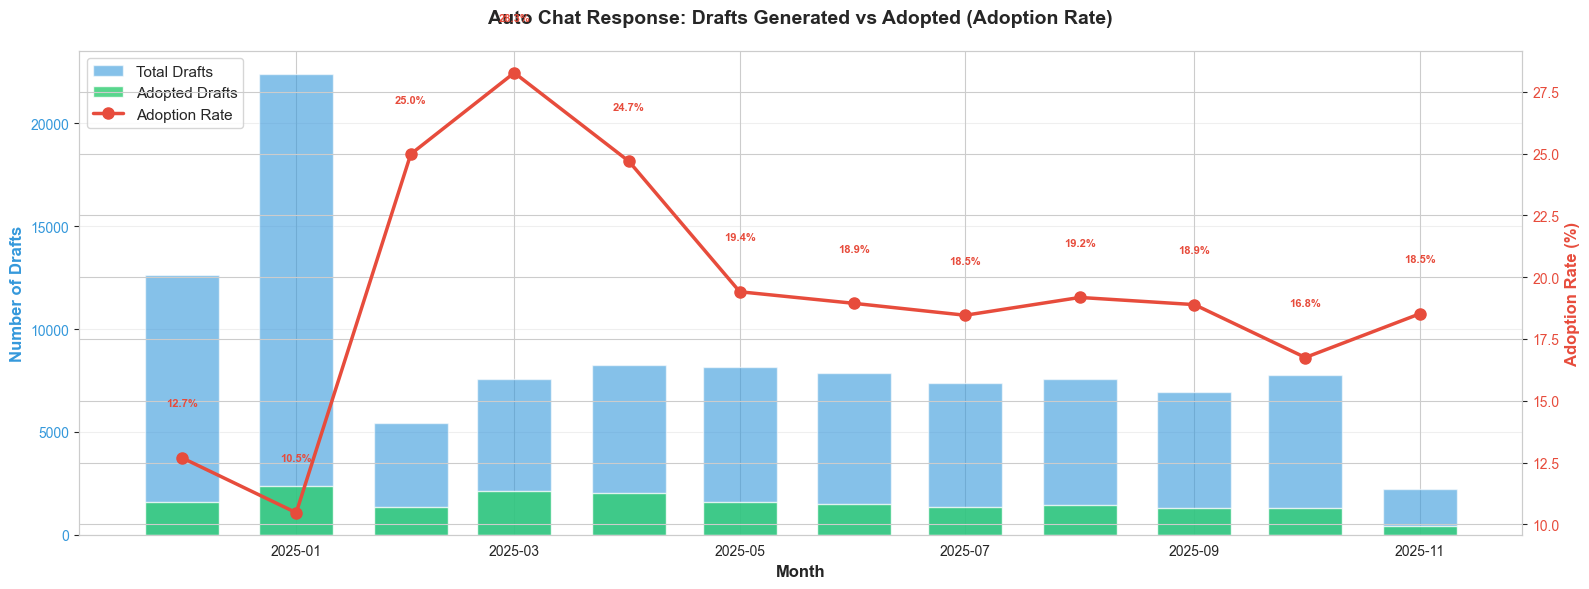

In [20]:
# Chart 1: Monthly Drafts and Adoption
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(16, 6))

# Drafts bars - use month_date for consistency
color1 = '#3498db'
ax1.set_xlabel('Month', fontweight='bold', fontsize=12)
ax1.set_ylabel('Number of Drafts', color=color1, fontweight='bold', fontsize=12)
bars1 = ax1.bar(df_monthly['month_date'], df_monthly['total_drafts'], alpha=0.6, color=color1, label='Total Drafts', width=20)
bars2 = ax1.bar(df_monthly['month_date'], df_monthly['adopted_drafts'], alpha=0.8, color='#2ecc71', label='Adopted Drafts', width=20)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(axis='y', alpha=0.3)

# Adoption rate line
ax2 = ax1.twinx()
color2 = '#e74c3c'
ax2.set_ylabel('Adoption Rate (%)', color=color2, fontweight='bold', fontsize=12)
line = ax2.plot(df_monthly['month_date'], df_monthly['adoption_rate'], 
                marker='o', linewidth=2.5, markersize=8, color=color2, label='Adoption Rate')
ax2.tick_params(axis='y', labelcolor=color2)

# Add value labels on line
for idx, row in df_monthly.iterrows():
    ax2.text(row['month_date'], row['adoption_rate'] + 2,
            f"{row['adoption_rate']:.1f}%",
            ha='center', va='bottom', fontsize=8, fontweight='bold', color=color2)

ax1.set_title('Auto Chat Response: Drafts Generated vs Adopted (Adoption Rate)', 
              fontweight='bold', fontsize=14, pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

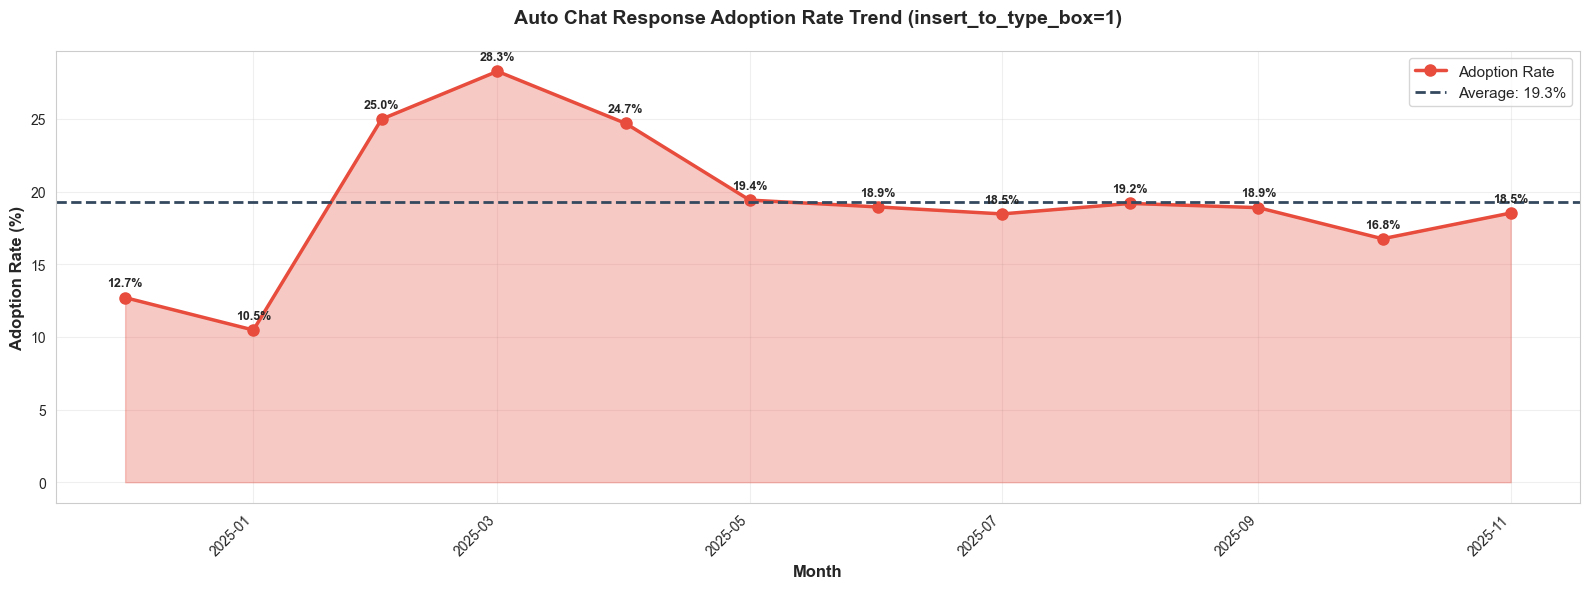

In [21]:
# Chart 2: Adoption Rate Trend
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df_monthly['month_date'], df_monthly['adoption_rate'], 
        marker='o', linewidth=2.5, markersize=8, color='#e74c3c', label='Adoption Rate')
ax.fill_between(df_monthly['month_date'], df_monthly['adoption_rate'], alpha=0.3, color='#e74c3c')

# Add value labels
for idx, row in df_monthly.iterrows():
    ax.text(row['month_date'], row['adoption_rate'] + df_monthly['adoption_rate'].max() * 0.02,
            f"{row['adoption_rate']:.1f}%",
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add average line
avg_adoption = df_monthly['adoption_rate'].mean()
ax.axhline(y=avg_adoption, color='#34495e', linestyle='--', linewidth=2, 
           label=f'Average: {avg_adoption:.1f}%')

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Adoption Rate (%)', fontweight='bold', fontsize=12)
ax.set_title('Auto Chat Response Adoption Rate Trend (insert_to_type_box=1)', 
             fontweight='bold', fontsize=14, pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

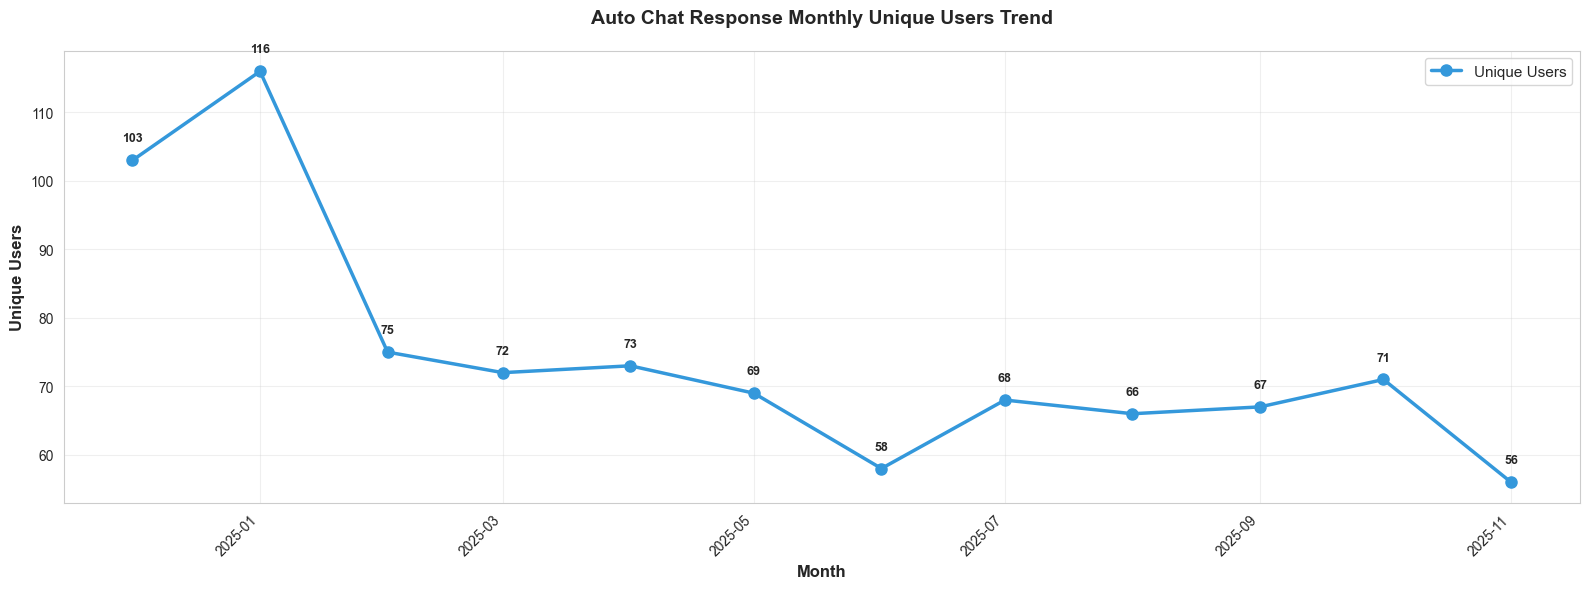

In [22]:
# Chart 3: Users Trend
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df_monthly['month_date'], df_monthly['unique_users'], 
        marker='o', linewidth=2.5, markersize=8, color='#3498db', label='Unique Users')

# Add value labels
for idx, row in df_monthly.iterrows():
    ax.text(row['month_date'], row['unique_users'] + df_monthly['unique_users'].max() * 0.02,
            f"{int(row['unique_users']):,}",
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Unique Users', fontweight='bold', fontsize=12)
ax.set_title('Auto Chat Response Monthly Unique Users Trend', fontweight='bold', fontsize=14, pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Part 2: User Details from MongoDB

In [23]:
# Get all unique user_ids
query_users = text("""
    SELECT DISTINCT user_id
    FROM ai.history_chat_draft
    WHERE timestamp >= '2024-01-01'
    ORDER BY user_id
""")

with mysql_engine.connect() as conn:
    user_ids_df = pd.read_sql(query_users, conn)

print(f"📊 Found {len(user_ids_df)} unique Auto Chat Response users")
print(f"\nSample user_ids:")
print(user_ids_df.head(10))

📊 Found 169 unique Auto Chat Response users

Sample user_ids:
                    user_id
0                      None
1  5a02483ebfac836b19df4474
2  5b5269d346237d0012f1546f
3  5b99d686137d2500121f7236
4  5bca4883cf36080012fb123f
5  5c53676bff867e00121bd789
6  5d1fd31948b93400135dc04d
7  5dc12503ea056a0013342a2f
8  5ddc76d471e28b00135e0c8c
9  5de5a634c73a0100159bf667


In [24]:
# Function to get user details from MongoDB
def get_user_details(user_id_str):
    """Get user details from MongoDB employees and role_assignments collections"""
    try:
        user_obj_id = ObjectId(user_id_str)
        
        # Get user info from employees collection
        user_doc = employees_collection.find_one({"_id": user_obj_id})
        
        # Get roles from role_assignments collection
        role_docs = list(role_assignments_collection.find({"memberId": user_obj_id}))
        unique_roles = list(set([doc.get('roleType') for doc in role_docs if doc.get('roleType')]))
        roles_str = ', '.join(sorted(unique_roles)) if unique_roles else 'N/A'
        
        if user_doc:
            return {
                'user_id': user_id_str,
                'name': user_doc.get('name', {}).get('full', 'N/A'),
                'first_name': user_doc.get('name', {}).get('first', 'N/A'),
                'last_name': user_doc.get('name', {}).get('last', 'N/A'),
                'email': user_doc.get('email', 'N/A'),
                'roles': roles_str,
                'status': user_doc.get('status', 'N/A'),
                'title': user_doc.get('title', 'N/A')
            }
        else:
            return {
                'user_id': user_id_str,
                'name': 'Not Found',
                'first_name': 'N/A',
                'last_name': 'N/A',
                'email': 'N/A',
                'roles': roles_str if unique_roles else 'N/A',
                'status': 'N/A',
                'title': 'N/A'
            }
    except Exception as e:
        return {
            'user_id': user_id_str,
            'name': f'Error: {str(e)}',
            'first_name': 'N/A',
            'last_name': 'N/A',
            'email': 'N/A',
            'roles': 'N/A',
            'status': 'N/A',
            'title': 'N/A'
        }

print("✅ User details function ready")

✅ User details function ready


In [25]:
# Fetch all user details from MongoDB
print("🔄 Fetching user details from MongoDB...\n")

user_details_list = []
for idx, row in user_ids_df.iterrows():
    user_id = row['user_id']
    user_info = get_user_details(user_id)
    user_details_list.append(user_info)
    
    # Progress indicator
    if (idx + 1) % 20 == 0:
        print(f"   Processed {idx + 1}/{len(user_ids_df)} users...")

# Create DataFrame
users_info_df = pd.DataFrame(user_details_list)

print(f"\n✅ Retrieved information for {len(users_info_df)} users")
print(f"\nSample user information:")
display(users_info_df.head(10))

🔄 Fetching user details from MongoDB...

   Processed 20/169 users...
   Processed 40/169 users...
   Processed 60/169 users...
   Processed 80/169 users...
   Processed 100/169 users...
   Processed 120/169 users...
   Processed 140/169 users...
   Processed 160/169 users...

✅ Retrieved information for 169 users

Sample user information:


,user_id,name,first_name,last_name,email,roles,status,title
0,None,Not Found,N/A,N/A,N/A,N/A,N/A,N/A
1,5a02483ebfac836b19df4474,N/A,N/A,N/A,vivian.hou@ihealthlabs.com,RD,ACTIVATED,N/A
2,5b5269d346237d0012f1546f,N/A,N/A,N/A,leah.wang@ihealthlabs.com,RD,ACTIVATED,N/A
3,5b99d686137d2500121f7236,N/A,N/A,N/A,nina.ghamrawi@ihealthlabs.com,"ADMIN, RD, SUPER_ADMIN",ACTIVATED,N/A
4,5bca4883cf36080012fb123f,N/A,N/A,N/A,yinqacu@yahoo.com,"CLINICAL_MANAGER, PROVIDER",ACTIVATED,N/A
5,5c53676bff867e00121bd789,N/A,N/A,N/A,darzandi19@yahoo.com,"CLINICAL_MANAGER, PROVIDER",ACTIVATED,N/A
6,5d1fd31948b93400135dc04d,N/A,N/A,N/A,elena.tian@ihealthlabs.com,"ADMIN, MANAGER, RD",ACTIVATED,N/A
7,5dc12503ea056a0013342a2f,N/A,N/A,N/A,grace.aguirre@ihealthlabs.com,RD,DEACTIVATED,N/A
8,5ddc76d471e28b00135e0c8c,N/A,N/A,N/A,zelin.chen@ihealthlabs.com,RD,ACTIVATED,N/A
9,5de5a634c73a0100159bf667,N/A,N/A,N/A,yiwen.lu@ihealthlabs.com,"ADMIN, RD",ACTIVATED,N/A


## Part 3: User Statistics with Adoption Metrics

In [26]:
# Get usage statistics per user with adoption metrics
query_user_stats = text("""
    SELECT 
        user_id,
        COUNT(*) as total_drafts,
        SUM(CASE WHEN insert_to_type_box = 1 THEN 1 ELSE 0 END) as adopted_drafts,
        ROUND(SUM(CASE WHEN insert_to_type_box = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as adoption_rate,
        SUM(CASE WHEN closed_by_user = 1 THEN 1 ELSE 0 END) as closed_drafts,
        COUNT(DISTINCT session_id) as total_sessions,
        MIN(timestamp) as first_use,
        MAX(timestamp) as last_use,
        COUNT(DISTINCT DATE_FORMAT(timestamp, '%Y-%m')) as active_months,
        SUM(total_tokens) as total_tokens
    FROM ai.history_chat_draft
    WHERE timestamp >= '2024-01-01'
    GROUP BY user_id
    ORDER BY total_drafts DESC
""")

with mysql_engine.connect() as conn:
    user_stats_df = pd.read_sql(query_user_stats, conn)

# Merge with user info
user_stats_with_info = user_stats_df.merge(
    users_info_df[['user_id', 'name', 'email', 'roles', 'title', 'status']], 
    on='user_id', 
    how='left'
)

print("📊 Top 20 Auto Chat Response Users with Adoption Metrics:\n")
display(user_stats_with_info.head(20))

📊 Top 20 Auto Chat Response Users with Adoption Metrics:



,user_id,total_drafts,adopted_drafts,adoption_rate,closed_drafts,total_sessions,first_use,last_use,active_months,total_tokens,name,email,roles,title,status
0,651f40008f3f4f0013284f57,5589,2408.0,43.08,109.0,0,2024-12-12 19:04:56,2025-11-11 00:01:13,12,58750588.0,N/A,breanne.okeefe@ihealthlabs.com,RD,N/A,ACTIVATED
1,67104da79d6e5166de679b61,5504,1989.0,36.14,10.0,0,2024-12-16 00:01:04,2025-09-04 03:58:35,10,45238203.0,N/A,lindsay.grady@ihealthlabs.com,RD,N/A,DEACTIVATED
2,63d4693c2c9f980013a804db,4862,705.0,14.50,37.0,0,2024-12-12 23:58:59,2025-07-26 03:32:10,8,40193673.0,N/A,fareen.aziz@ihealthlabs.com,RD,N/A,DEACTIVATED
3,5f1f5edf5c79e50013de2871,4780,1102.0,23.05,96.0,0,2024-12-12 18:49:01,2025-11-10 22:58:23,12,36312485.0,N/A,dongwan.zhu@ihealthlabs.com,RD,N/A,ACTIVATED
4,6799276414cda46a347382e7,4327,432.0,9.98,24.0,0,2025-02-12 22:27:43,2025-11-08 00:15:04,10,28475363.0,N/A,suzette.olsen@ihealthlabs.com,HC,N/A,ACTIVATED
5,6578afc0f7a6bd00131b2561,4206,434.0,10.32,147.0,0,2024-12-13 14:13:15,2025-11-10 20:21:52,12,26305459.0,N/A,valerie.deleon@ihealthlabs.com,HC,N/A,ACTIVATED
6,5ed7dbaa7214b300139c9d8d,3827,3.0,0.08,82.0,0,2024-12-17 17:17:24,2025-11-05 23:58:08,12,26131383.0,N/A,vy.phung@ihealthlabs.com,"CA, HC",N/A,ACTIVATED
7,6490e6ee446be000137642d5,3660,1142.0,31.20,39.0,0,2024-12-12 18:53:18,2025-11-10 23:58:53,12,32448578.0,N/A,ngocanhthu.ho@ihealthlabs.com,RD,N/A,ACTIVATED
8,65effe4e7274a0644f4fb6b2,3623,223.0,6.16,25.0,0,2024-12-12 20:18:35,2025-11-10 23:40:08,12,32147925.0,N/A,kayi.ng@ihealthlabs.com,RD,N/A,ACTIVATED
9,66a9262c55a933735f9f9c0d,3507,259.0,7.39,65.0,0,2024-12-12 22:55:19,2025-11-11 00:09:27,12,24680129.0,N/A,maria.blandon@ihealthlabs.com,RD,N/A,ACTIVATED


In [27]:
# Summary by roles
print("📋 Usage by Role:\n")
role_summary = user_stats_with_info.groupby('roles').agg({
    'user_id': 'count',
    'total_drafts': 'sum',
    'adopted_drafts': 'sum',
    'closed_drafts': 'sum',
    'total_sessions': 'sum',
    'total_tokens': 'sum'
}).rename(columns={
    'user_id': 'user_count'
})

# Calculate adoption rate by role
role_summary['adoption_rate'] = (role_summary['adopted_drafts'] / role_summary['total_drafts'] * 100).round(2)

role_summary = role_summary.sort_values('total_drafts', ascending=False)

display(role_summary.head(15))

📋 Usage by Role:



,user_count,total_drafts,adopted_drafts,closed_drafts,total_sessions,total_tokens,adoption_rate
roles,,,,,,,
RD,30,56549,12267.0,1146.0,0,493281234.0,21.69
CA,50,15557,1396.0,714.0,0,105170684.0,8.97
HC,7,12874,1162.0,1030.0,0,85685521.0,9.03
"CA, HC",10,8270,1590.0,130.0,0,58772515.0,19.23
"HC, RD",4,5024,1095.0,181.0,0,43135044.0,21.80
"ADMIN, CA, HC",6,3533,551.0,11.0,0,37198766.0,15.60
"CA, MANAGER",1,563,10.0,4.0,0,5432141.0,1.78
"MA, PROVIDER",3,429,59.0,4.0,0,900126.0,13.75
MA,15,421,34.0,48.0,0,1157564.0,8.08


In [28]:
# Adoption rate distribution
print("📊 Adoption Rate Distribution:\n")

# Create bins for adoption rate
user_stats_with_info['adoption_bucket'] = pd.cut(
    user_stats_with_info['adoption_rate'], 
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
)

adoption_dist = user_stats_with_info.groupby('adoption_bucket').agg({
    'user_id': 'count',
    'total_drafts': 'sum',
    'adopted_drafts': 'sum'
}).rename(columns={'user_id': 'user_count'})

display(adoption_dist)

📊 Adoption Rate Distribution:



,user_count,total_drafts,adopted_drafts
adoption_bucket,,,
0-20%,83,65847,4961.0
21-40%,13,24002,6673.0
41-60%,12,13468,6628.0
61-80%,2,211,143.0
81-100%,0,0,0.0


## Export Results

In [29]:
# Export monthly statistics
output_monthly_csv = '/Users/sagegu/Documents/ai_data_analysis/auto_chat_monthly_results.csv'
df_monthly.to_csv(output_monthly_csv, index=False)
print(f"✅ Monthly results exported to: {output_monthly_csv}")

# Export user statistics with details
output_users_csv = '/Users/sagegu/Documents/ai_data_analysis/auto_chat_users_details.csv'
user_stats_with_info.to_csv(output_users_csv, index=False)
print(f"✅ User details exported to: {output_users_csv}")

# Export role summary
output_roles_csv = '/Users/sagegu/Documents/ai_data_analysis/auto_chat_by_role.csv'
role_summary.to_csv(output_roles_csv)
print(f"✅ Role summary exported to: {output_roles_csv}")

print(f"\n📊 Summary:")
print(f"   Total months: {len(df_monthly)}")
print(f"   Total users: {len(user_stats_with_info)}")
print(f"   Total drafts: {df_monthly['total_drafts'].sum():,}")
print(f"   Total adopted: {df_monthly['adopted_drafts'].sum():,}")
print(f"   Overall adoption rate: {(df_monthly['adopted_drafts'].sum() / df_monthly['total_drafts'].sum() * 100):.2f}%")

✅ Monthly results exported to: /Users/sagegu/Documents/ai_data_analysis/auto_chat_monthly_results.csv
✅ User details exported to: /Users/sagegu/Documents/ai_data_analysis/auto_chat_users_details.csv
✅ Role summary exported to: /Users/sagegu/Documents/ai_data_analysis/auto_chat_by_role.csv

📊 Summary:
   Total months: 12
   Total users: 169
   Total drafts: 104,251
   Total adopted: 18,404.0
   Overall adoption rate: 17.65%


## Cleanup

In [30]:
# Close all connections
mysql_engine.dispose()
mongo_client.close()

print("✅ MySQL connection closed")
print("✅ MongoDB connection closed")
print("\n" + "=" * 70)
print("🎉 ANALYSIS COMPLETE!")
print("=" * 70)

✅ MySQL connection closed
✅ MongoDB connection closed

🎉 ANALYSIS COMPLETE!
